In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [3]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [4]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
df_trainval

,atr_ratio,atr_ratio_sma,vol_15,bb_width_20,r_5,r_15,rsi,stoch_d_3,stoch_k_14,hour,eng_adx,eng_obv,eng_ma,bid,ask,signal,pred_signal,close_mid
2004-01-02 14:07:00,-0.971426,-0.960594,-1.014295,-0.815439,-0.067706,-0.120566,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.861562,-0.001209,0.762693,0.763836,1.000000,0.152649,0.763265
2004-01-02 14:08:00,-0.971405,-0.960547,-1.014295,-0.815436,-0.067708,-0.120569,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.875888,-0.001209,0.762676,0.763819,1.000000,0.163121,0.763248
2004-01-02 14:09:00,-0.971384,-0.960503,-1.014295,-0.815434,-0.067709,-0.120571,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.890215,-0.001209,0.762660,0.763802,1.000000,0.173416,0.763231
2004-01-02 14:10:00,-0.971366,-0.960462,-1.014295,-0.815431,-0.067711,-0.120574,-2.476841,-1.585648,-1.552562,0.263,-2.981712,-0.904541,-0.001209,0.762643,0.763786,1.000000,0.183218,0.763214
2004-01-02 14:11:00,-0.923613,-0.958038,-0.768664,-0.799708,0.288413,0.090469,0.776847,-1.236847,-0.528223,0.263,0.889356,-0.731059,-0.001209,0.763071,0.764215,1.000000,0.192371,0.763643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 20:56:00,-0.030164,-0.214860,0.189349,-0.261620,1.428264,0.648909,0.631314,0.927657,1.224401,-0.941,-0.027995,0.178939,2.227838,175.238500,175.501500,0.331709,0.228158,175.370000
2022-03-28 20:57:00,-0.026538,-0.202050,0.178457,-0.130963,1.768150,0.788302,0.754476,1.199615,1.302253,-0.941,-0.019207,0.300146,4.171111,175.316000,175.579200,0.178033,0.272352,175.447600
2022-03-28 20:58:00,-0.021015,-0.188697,0.194997,0.077383,1.705393,1.050869,0.947666,1.354806,1.451027,-0.941,0.040347,0.438921,6.571623,175.453300,175.716700,0.074610,0.328041,175.585000
2022-03-28 20:59:00,0.020089,-0.173398,0.194389,0.237859,1.217749,1.112840,0.954325,1.379467,1.296826,-0.941,0.116959,0.758549,8.457740,175.458300,175.721700,0.002711,0.377916,175.590000


In [5]:
# Pre-compute per-day slices once
groups = list(df_trainval.groupby(df_trainval.index.normalize()))

def objective(trial: optuna.Trial) -> float:
    """
    Optuna objective:
      1) Suggest pred_threshold, trailing_stop_pred, smoothing_window
      2) For each day:
         a) Causally smooth `pred_signal` over the last `smoothing_window` minutes
         b) Generate discrete actions on the smoothed signal
         c) Run 1‐day backtest, collect P&L
      3) Report daily P&L for pruning, return average daily P&L
    """

    print('Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......')
    
    smoothing_window   = trial.suggest_int("smoothing_window", 1, 60)
    pred_threshold     = trial.suggest_float("pred_threshold",     0.10, 0.80)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.08)

    daily_pnls: List[float] = []

    print('')
    for step, (day, df_day) in enumerate(
        tqdm(groups, desc=f"Trial {trial.number}", leave=False), 1
    ):
        # Causal smoothing of the raw pred_signal
        df_proc = df_day.copy()
        df_proc["pred_signal_smoothed"] = (
            df_proc["pred_signal"]
              .rolling(window=smoothing_window, min_periods=1)
              .mean()
        )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_proc,
            col_signal        = "pred_signal_smoothed",
            col_action        = "pred_action",
            buy_threshold     = pred_threshold,
            trailing_stop_pct = trailing_stop_pred,
            sess_start        = params.sess_start,
            col_close         = "close_mid",
        )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            results_by_day_sign = {day.date(): (df_actions, [])},
            col_action          = "pred_action",
            sess_start          = params.sess_start,
            sess_end            = params.sess_end
        )
        _, _, stats = next(iter(sim.values()))
        daily_pnls.append(stats["Strategy Return ($)"])

        # Explicitly delete large locals at the end of each trial
        del df_proc, df_actions, sim, stats
        gc.collect()
        torch.cuda.empty_cache()

        # Rreport for pruning
        trial.report(daily_pnls[-1], step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


[I 2025-09-08 15:41:27,440] A new study created in RDB with name: no-name-e6d9924a-b40e-44a7-b889-2d3f707b70eb


Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 0:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-09-08 15:59:04,035] Trial 0 finished with value: -0.03648137660640383 and parameters: {'smoothing_window': 4, 'pred_threshold': 0.5620073436959796, 'trailing_stop_pred': 0.043217879343206554}. Best is trial 0 with value: -0.03648137660640383.


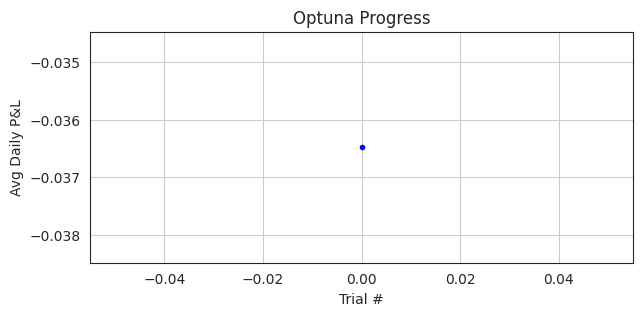

Processing hyperparameters, generate actions on the smoothed predicted signal, and simulate trading......



Trial 1:   0%|          | 0/4591 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7c1d68c9dee0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7c1d68c9dee0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
n_trials = 200
n_jobs = 1

pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=60)

study = optuna.create_study( # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    storage=f"sqlite:///{os.path.join(params.optuna_folder, "optuna_study_predicted.db")}", 
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_results_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{first_day}-{last_day}_optuna_predicted_{study.best_value}_{params.model_path}.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")